### Pipeline

1) Generating images
2) Generating text images with empty background
3) Combining images with texts using replicate
4) Combining new images into a video using shot stack


In [ ]:
!pip install -q transformers accelerate torch
!pip install -q diffusers==0.31.0 safetensors accelerate
!nvidia-smi || true
!pip install pillow
!pip install sacremoses
!pip install replicate

# Fonts
!sudo apt -y update >/dev/null
!sudo apt -y install fonts-dejavu fonts-freefont-ttf fonts-noto-core >/dev/null
!wget -q https://github.com/google/fonts/raw/main/ofl/lobster/Lobster-Regular.ttf -O /usr/share/fonts/truetype/lobster.ttf
!wget -q https://github.com/google/fonts/raw/main/ofl/montserrat/Montserrat-Bold.ttf -O /usr/share/fonts/truetype/montserrat-bold.ttf
!fc-cache -f

# Fonts
!apt-get -y update -qq
!apt-get -y install -qq fonts-dejavu fonts-dejavu-core fonts-dejavu-extra fonts-freefont-ttf fonts-noto-core
!fc-cache -f

import re, torch, os, random, glob, unicodedata as ud
import asyncio
import replicate
import requests
import json
from typing import List
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from uuid import UUID, uuid4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 97.2 MB/s eta 0:00:00
Tue Nov 25 17:38:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                    

In [ ]:
import os
os.environ["REPLICATE_API_TOKEN"] = "x"
os.environ["SHOT_STACK_API_TOKEN"] = "y"


In [ ]:
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE    = torch.float16 if DEVICE == "cuda" else torch.float32
W, H     = 512, 512
LORA_DIR = "/content"
WT_NAME  = "pytorch_lora_weights.safetensors"
BASE     = "Manojb/stable-diffusion-2-1-base"

ruen_tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
ruen_mt  = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(DEVICE).eval()

@torch.inference_mode()
def ru2en(text: str) -> str:
    enc = ruen_tok(text.strip(), return_tensors="pt").to(DEVICE)
    out = ruen_mt.generate(**enc, max_new_tokens=64)
    return ruen_tok.batch_decode(out, skip_special_tokens=True)[0].strip()

CYR = re.compile(r"[А-Яа-яЁё]")
def to_english(s: str) -> str:
    return ru2en(s) if CYR.search(s) else s.strip()

q_model_id = "Qwen/Qwen2.5-1.5B-Instruct"
q_tok = AutoTokenizer.from_pretrained(q_model_id)
q_llm = AutoModelForCausalLM.from_pretrained(q_model_id, torch_dtype=DTYPE).to(DEVICE).eval()

SYSTEM = (
    "You rewrite a short holiday/topic into three concise Stable Diffusion XL prompts for a festive POSTCARD.\n"
    "- Keep each line concrete and short (<= 48 words).\n"
    "- Focus on specific subjects and simple composition (what/where/background).\n"
    "- Allowed: pastel background, soft bokeh, glitter sparkles, glossy highlights, photomontage postcard style.\n"
    "- Must include: 'postcard, no text'.\n"
    "- FORBIDDEN: masterpiece, 8k, absurdres, by <artist>, nsfw, anatomy, camera brands, friends, family, group, people, girl, boy, man, woman\n"
    "- Avoid winter/snow/Christmas motifs unless the topic explicitly mentions them.\n"
    "- Output exactly three lines, no numbering."
)

EXAMPLES = (
    "Examples:\n"
    "Valentine's Day -> picture of two kittens sitting inside a big pink heart, sparkles and roses, pastel background, no text\n"
    "International Women's Day -> pink roses and satin ribbon arranged neatly, pastel gradient background, soft bokeh, postcard, no text\n"
    "Easter -> yellow chick emerging from decorated egg shell, surrounded by spring flowers, pastel pink and green background, glitter sparkles, glossy highlights, photomontage postcard style, no humans, no text\n"
    "Christmas -> white dove flying over red roses, glowing sunset, sparkles, high saturation, no text\n"
)

def normalize_topic(en_text: str) -> str:
    t = en_text.strip().lower()
    if t in {"8 march", "march 8", "8th march"}:
        return "International Women's Day"
    return en_text.strip()

def build_chat_inputs(topic_en: str):
    messages = [
        {"role": "system", "content": SYSTEM + "\n" + EXAMPLES},
        {"role": "user",   "content": f"Topic: {topic_en}\nReturn 3 lines, one per prompt."}
    ]

    prompt_text = q_tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    enc = q_tok(prompt_text, return_tensors="pt", padding=True).to(DEVICE)
    return enc

BLACK = [
    r"\bmasterpiece\b", r"\b8k\b", r"\babsurdres\b",
    r"\b(anatomy|nsfw)\b", r"\bby\s+[A-Z][a-z]+\b", r"\bdslr\b"
]

def sanitize_line(line: str, max_words=48) -> str:
    t = line.strip()
    t = re.sub(r"^\s*\d+\s*[\.\)\-:]\s*", "", t)
    for patt in BLACK:
        t = re.sub(patt, "", t, flags=re.IGNORECASE)
    t = re.sub(r"\s*,\s*", ", ", t)
    t = re.sub(r"(,\s*){2,}", ", ", t).strip(" ,")
    low = t.lower()
    if "postcard" not in low: t += ", postcard"
    if "no text" not in low:  t += ", no text"
    words = t.split()
    if len(words) > max_words: t = " ".join(words[:max_words])
    return t

@torch.inference_mode()
def make_three_prompts(user_text: str, temperature=0.2) -> dict:
    topic_en = normalize_topic(to_english(user_text))
    enc = build_chat_inputs(topic_en)
    out = q_llm.generate(
        **enc, max_new_tokens=200, do_sample=True, temperature=temperature,
        top_p=0.8, repetition_penalty=1.05,
        eos_token_id=q_tok.eos_token_id, pad_token_id=q_tok.eos_token_id
    )
    raw = q_tok.decode(out[0, enc["input_ids"].shape[-1]:], skip_special_tokens=True)
    lines = [s.strip() for s in raw.splitlines() if s.strip()]
    lines = lines[:5] if len(lines) >= 5 else (lines + [""]*(5-len(lines)))
    clean = [sanitize_line(l) if l else
             "festive postcard scene with fitting symbols, pastel background, soft bokeh, glitter sparkles, postcard, no text"
             for l in lines]
    neg = "text, letters, watermark, logo, low quality, blurry, jpeg artifacts, duplicates, extra limbs, extra heads, people, bad anatomy"
    return {"topic_en": topic_en, "prompts": clean, "negative": neg}



pipe = StableDiffusionPipeline.from_pretrained(
    BASE, torch_dtype=torch.float16
).to(DEVICE)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


pipe.enable_attention_slicing()
pipe.enable_vae_slicing()
pipe.enable_vae_tiling()

# LoRA
pipe.load_lora_weights(LORA_DIR, weight_name=WT_NAME)


def gen(prompt: str, outfile: str, negative: str,
        steps=24, cfg=6.2, w=512, h=512, seed=1234):
    g = torch.Generator(device=DEVICE).manual_seed(seed)
    image = pipe(
        prompt=prompt, negative_prompt=negative,
        num_inference_steps=steps, guidance_scale=cfg,
        width=w, height=h, generator=g
    ).images[0]
    image.save(outfile)
    return image

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


EN topic: New Year
Prompt 1: New Year's Eve fireworks display, city skyline at night, soft bokeh, glitter sparkles, pastel background, postcard, no text
Prompt 2: A snowman in a cozy cabin, morning sunlight, soft bokeh, glitter sparkles, glossy highlights, photomontage postcard style, no text
Prompt 3: A family gathered around a tree, Christmas lights twinkling, soft bokeh, glitter sparkles, pastel background, postcard, no text
Prompt 4: festive postcard scene with fitting symbols, pastel background, soft bokeh, glitter sparkles, postcard, no text
Prompt 5: festive postcard scene with fitting symbols, pastel background, soft bokeh, glitter sparkles, postcard, no text
NEG: text, letters, watermark, logo, low quality, blurry, jpeg artifacts, duplicates, extra limbs, extra heads, people, bad anatomy


  0%|          | 0/24 [00:00<?, ?it/s]

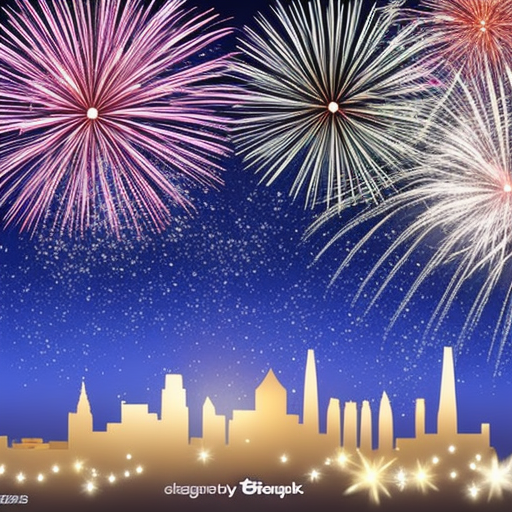

  0%|          | 0/24 [00:00<?, ?it/s]

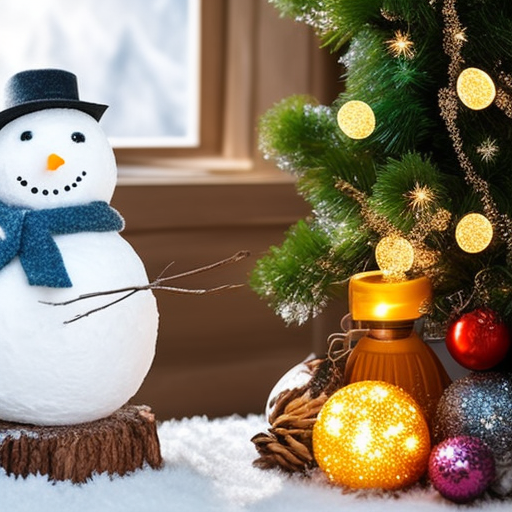

  0%|          | 0/24 [00:00<?, ?it/s]

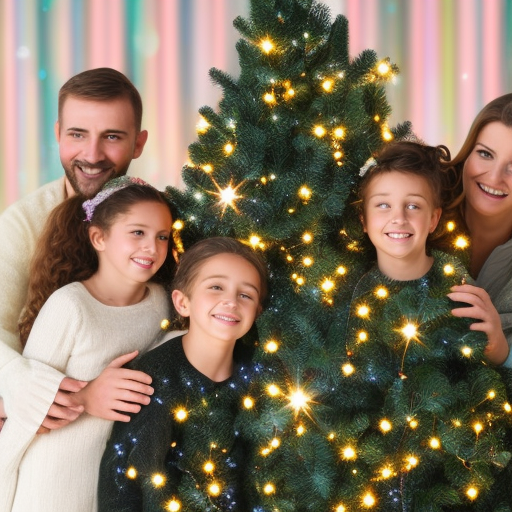

  0%|          | 0/24 [00:00<?, ?it/s]

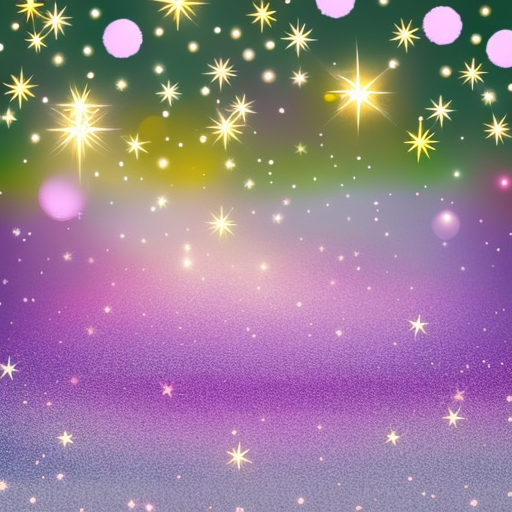

  0%|          | 0/24 [00:00<?, ?it/s]

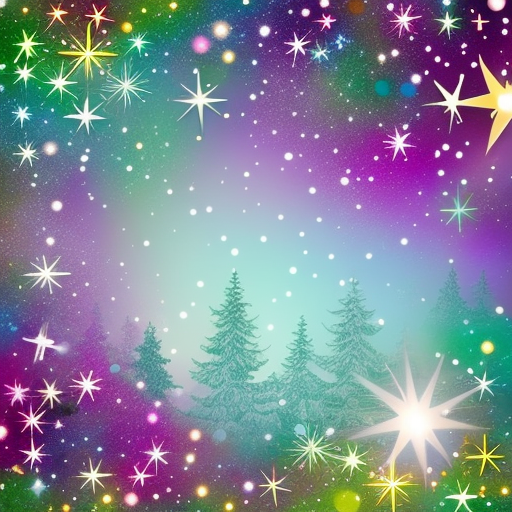

In [ ]:
# Images
INPUT_PATH = "/content/resources/"
user_text = "Новый год" # input()


pack = make_three_prompts(user_text)
print("EN topic:", pack["topic_en"])
for i, p in enumerate(pack["prompts"], 1):
    print(f"Prompt {i}: {p}")
print("NEG:", pack["negative"])

imgs = []
image_filenames = []
for i, p in enumerate(pack["prompts"], 1):
    try:
        file_name = INPUT_PATH + uuid4().hex + ".png"
        img = gen(p, file_name, negative=pack["negative"], seed=1000+i)
        image_filenames.append(file_name)
        imgs.append(img); display(img)
    except Exception as e:
        print(e)

In [ ]:
# Texts

MODEL_NAME = os.environ.get("SLOGAN_LLM", "Qwen/Qwen2.5-1.5B-Instruct")
K_OUT      = 3
SEED       = 23
BG_DEFAULT = "transparent"      # "transparent" | "white"
PALETTE    = [(231,76,60),(46,204,113),(52,152,219),(155,89,182),(241,196,15),(20,20,20)]

SYS = (
    "You output ultra-short keywords. "
    "Language: {lang}. One variant per line, no numbering. "
    "1 to {maxw} words. No punctuation, quotes, emoji, hashtags."
)

SAFE_FAMILIES = ("DejaVuSans", "NotoSans")

random.seed(SEED); torch.manual_seed(SEED)

def collect_fonts() -> list[Path]:
    roots = ("/usr/share/fonts", "/usr/local/share/fonts")
    keep = []
    for d in roots:
        keep += [Path(p) for p in glob.glob(os.path.join(d, "**", "DejaVuSans*.ttf"), recursive=True)]
        keep += [Path(p) for p in glob.glob(os.path.join(d, "**", "NotoSans*.ttf"),   recursive=True)]
    order = {"DejaVuSans.ttf":0, "DejaVuSans-Bold.ttf":1, "DejaVuSans-Oblique.ttf":2,
             "NotoSans-Regular.ttf":3, "NotoSans-Bold.ttf":4, "NotoSans-Italic.ttf":5}
    keep = [p for p in keep if p.exists()]
    keep.sort(key=lambda p: (order.get(p.name, 99), p.name))
    return keep


def font_supports_text(font_path: Path, text: str) -> bool:
    try:
        f = ImageFont.truetype(str(font_path), size=28)
    except Exception:
        return False
    for ch in text:
        if ch in " -":
            continue
        try:
            bbox = f.getbbox(ch)
        except Exception:
            try:
                w,h = f.getsize(ch); bbox = (0,0,w,h)
            except Exception:
                return False
        if not bbox or (bbox[2]-bbox[0]) <= 0 or (bbox[3]-bbox[1]) <= 0:
            return False
    return True

def load_llm():
    tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, torch_dtype=DTYPE, device_map="auto", trust_remote_code=True
    )
    return tok, model

def detect_lang(text: str) -> str:
    return "ru" if re.search(r"[\u0400-\u04FF]", text) else "en"

def sanitize(text: str, lang: str) -> str:
    t = ud.normalize("NFKC", text)
    t = t.replace("\u00A0", " ").replace("\u2009", " ").replace("\u202F", " ")
    t = re.sub(r"[\"""'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    allow = r"[^\u0400-\u04FF0-9\- ]" if lang == "ru" else r"[^A-Za-z0-9\- ]"
    t = re.sub(allow, "", t)
    t = re.sub(r"\s+", " ", t).strip()
    if re.search(r"\d{4}", t):
        t = re.sub(r"\d{4}", "", t).strip()
    return t

def gen_phrases(topic: str, lang: str, k: int) -> list[str]:
    tok, model = load_llm()
    RX = re.compile(r"^[\u0400-\u04FF0-9\- ]{1,40}$") if lang=="ru" else re.compile(r"^[A-Za-z0-9\- ]{1,40}$")

    examples = {
        "ru": "Примеры:\nС Новым годом\nС Рождеством\nЗимняя сказка\nТёплых праздников",
        "en": "Examples:\nMerry Christmas\nHappy New Year\nHoliday cheer\nWarm wishes",
    }
    script_rule = "Use only Cyrillic letters (А-Я, а-я)." if lang=="ru" else "Use only Latin letters (A–Z, a–z)."

    def ask_one() -> str:
        sys_prompt = (
            f"Generate ONE ultra-short greeting/tagline. Language: {lang}. "
            "1–4 words. No quotes, punctuation, emoji, hashtags. "
            + script_rule + "\n" + examples[lang]
        )
        user = f"Topic: {topic}\nReturn only the phrase on the first line."
        if hasattr(tok, "apply_chat_template"):
            prompt = tok.apply_chat_template(
                [{"role":"system","content":sys_prompt},
                 {"role":"user","content":user}],
                tokenize=False, add_generation_prompt=True
            )
        else:
            prompt = sys_prompt + "\n" + user + "\nAssistant:\n"

        enc = tok(prompt, return_tensors="pt"); enc = {k:v.to(model.device) for k,v in enc.items()}
        out = model.generate(**enc, max_new_tokens=48, temperature=0.6, top_p=0.85,
                             do_sample=True, repetition_penalty=1.08,
                             eos_token_id=getattr(tok,"eos_token_id",None))
        new = out[0, enc["input_ids"].shape[1]:]
        raw = tok.decode(new, skip_special_tokens=True)
        s = raw.splitlines()[0].strip() or re.split(r"[,\uFF0C;]+", raw)[0].strip()
        s = ud.normalize("NFKC", s)
        s = re.sub(r"[\"""'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", s)
        s = re.sub(r"\s+", " ", s).strip()
        s = re.sub(r"[^\u0400-\u04FF0-9\- ]","",s) if lang=="ru" else re.sub(r"[^A-Za-z0-9\- ]","",s)
        s = re.sub(r"\s+"," ",s).strip()
        return s

    res, seen, tries = [], set(), 0
    topic_norm = re.sub(r"\s+"," ", topic.lower()).strip()
    while len(res) < k and tries < k*10:
        tries += 1
        s = ask_one()
        if not s or not RX.match(s):
            continue
        if not (1 <= len(s.split()) <= 4):
            continue
        key = s.lower()
        if key == topic_norm or key in {"system","assistant","user","topic"}:
            continue
        if key in seen:
            continue
        seen.add(key); res.append(s)
    return res


def fit_font(font_path: Path, text: str, draw: ImageDraw.ImageDraw, w: int, h: int):
    lo, hi, best = 14, 260, None
    while lo <= hi:
        mid = (lo + hi)//2
        try:
            f = ImageFont.truetype(str(font_path), size=mid)
        except Exception:
            f = ImageFont.load_default()
        x0,y0,x1,y1 = draw.textbbox((0,0), text, font=f)
        if (x1-x0) <= w and (y1-y0) <= h:
            best = f; lo = mid + 1
        else:
            hi = mid - 1
    return best or ImageFont.load_default()

def render_phrase(text: str, font_path: Path, color=(20,20,20), bg="transparent"):
    fonts = collect_fonts()
    use = next((p for p in fonts if p.name.endswith("Bold.ttf")), fonts[0])

    mode = "RGBA" if bg=="transparent" else "RGB"
    img  = Image.new(mode, (W,H), (0,0,0,0) if mode=="RGBA" else (255,255,255))
    draw = ImageDraw.Draw(img)
    font = fit_font(use, text, draw, W-60, H-40)
    x0,y0,x1,y1 = draw.textbbox((0,0), text, font=font)
    x,y = (W-(x1-x0))//2, (H-(y1-y0))//2
    stroke = (0,0,0,200) if mode=="RGBA" else (0,0,0)
    draw.text((x,y), text, font=font, fill=color, stroke_width=2, stroke_fill=stroke)

    file_name = uuid4().hex
    file_path = os.path.join(INPUT_PATH, file_name + '.png')
    img.save(file_path)
    return img, file_path


# main function
def generate_and_display(topic: str, lang: str="auto", bg: str=BG_DEFAULT, k: int=K_OUT):
    fonts = collect_fonts()
    if not fonts:
        raise SystemExit("No fonts found. Install DejaVu/Noto.")
    lang = detect_lang(topic) if lang=="auto" else lang

    phrases = gen_phrases(topic, lang, k)
    if len(phrases) < k:
        need = k - len(phrases)
        extra = gen_phrases(topic + " variations", lang, need)
        for p in extra:
            if p.lower() not in {x.lower() for x in phrases}:
                phrases.append(p)
            if len(phrases) == k:
                break
    if not phrases:
        phrases = [sanitize(topic, lang)]

    base = next((p for p in fonts if "DejaVuSans" in p.name), fonts[0])
    alt  = next((p for p in fonts if "NotoSans"  in p.name), fonts[min(1, len(fonts)-1)])
    font_pool = [base, alt] + random.sample(fonts, k=min(3, len(fonts)))

    text_filenames = []
    for t in phrases[:k]:
        img, file_path = render_phrase(t, random.choice(font_pool), color=random.choice(PALETTE), bg=bg)
        display(img)
        text_filenames.append(file_path)
    return text_filenames, phrases[:k]

<>:64: SyntaxWarning: invalid escape sequence '\['
<>:107: SyntaxWarning: invalid escape sequence '\['
<>:64: SyntaxWarning: invalid escape sequence '\['
<>:107: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-137560257.py:64: SyntaxWarning: invalid escape sequence '\['
  t = re.sub(r"[\"""'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", t)
/tmp/ipython-input-137560257.py:107: SyntaxWarning: invalid escape sequence '\['
  s = re.sub(r"[\"""'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", s)


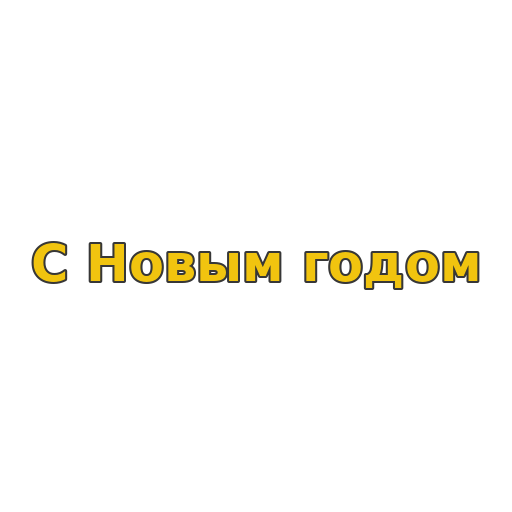

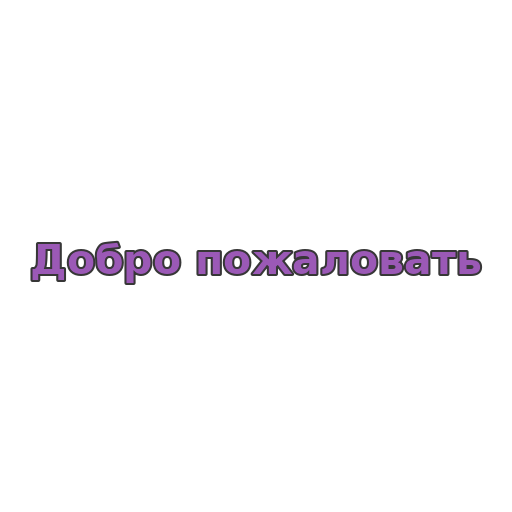

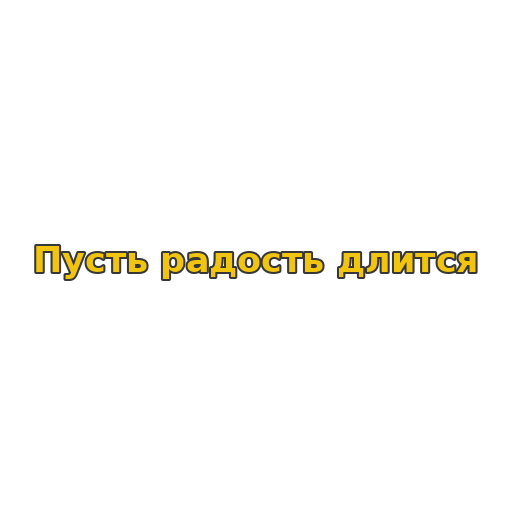

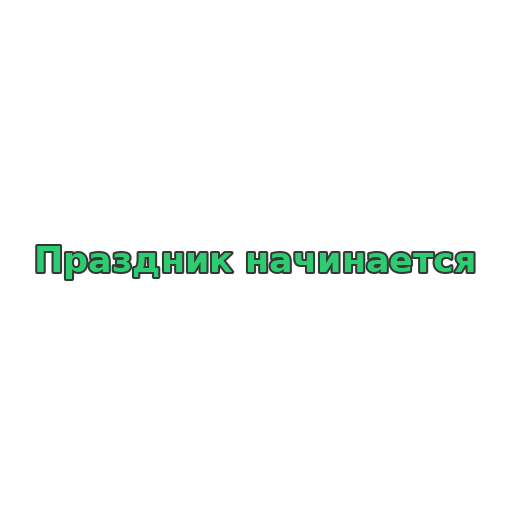

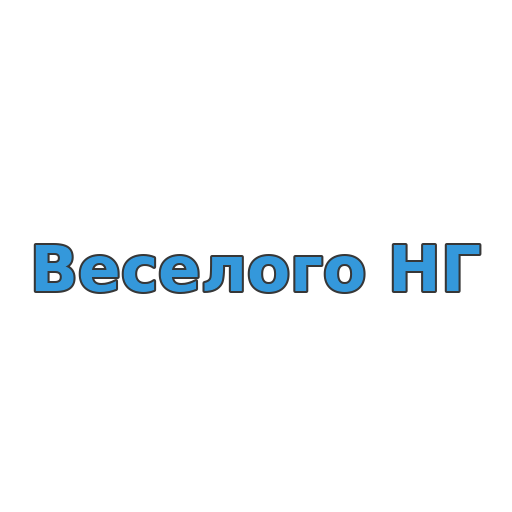

In [ ]:
text_filenames, text_phrases = generate_and_display(user_text, k=5)

In [ ]:
import os
import asyncio
from uuid import uuid4
import replicate

COMBINATION_PROMPT = (
    "Add an inscription from the second image to the top or to the bottom of the first image. "
    "Do not add any extra text that is not on my images. "
    "You can move the text freely to the best location. "
    "The result should look like a card my grandmother might send me."
)

# один общий клиент, использующий REPLICATE_API_TOKEN из окружения
client = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])

MODEL_VERSION = "bytedance/seedream-4:3ee3b70df63b39e425ccb0188d3c14961177c11fa20516d9dfd30a868b41b2d5"


async def add_text_to_image(
    text_image_path: str,
    main_image_path: str,
    output_dir: str = "image_outputs",
    output_size: str = "1K",
    aspect_ratio: str = "1:1",
    save_locally: bool = True,
) -> tuple[str, str]:
    """
    Combine one main image with one text image (async version).
    REPLICATE_API_TOKEN должен быть задан в окружении.
    """

    # загружаем картинки на Replicate (синхронно, но это быстро)
    with open(text_image_path, "rb") as f:
        text_image = client.files.create(f)

    with open(main_image_path, "rb") as f:
        main_image = client.files.create(f)

    input_data = {
        "size": output_size,
        "prompt": COMBINATION_PROMPT,
        "aspect_ratio": aspect_ratio,
        "image_input": [main_image.urls["get"], text_image.urls["get"]],
    }

    # асинхронный запуск модели
    output = await client.async_run(MODEL_VERSION, input=input_data)
    # output – список URL готовых картинок
    url = str(output[0])

    local_filename = ""
    if save_locally:
        os.makedirs(output_dir, exist_ok=True)
        file_name = uuid4().hex + ".jpg"
        local_path = os.path.join(output_dir, file_name)

        # простое скачивание через requests (синхронно; если захочешь – заменишь на aiohttp)
        import requests

        resp = requests.get(url)
        resp.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(resp.content)

        local_filename = local_path

    return url, local_filename


# пример параллельного запуска
results = await asyncio.gather(*[
    add_text_to_image(text_filenames[i], image_filenames[i], output_dir="image_outputs")
    for i in range(len(text_filenames))
])

images_with_text = [url for url, _ in results]
images_with_text_paths = [path for _, path in results]

print(f"Generated {len(images_with_text)} images")
print("URLs:", images_with_text)
print("Local paths:", images_with_text_paths)


Generated 5 images
URLs: ['https://replicate.delivery/xezq/rSd53PkipMrTHpevnyp8YdmGgmtfh59p86jJKJykzll075sVA/tmpyj3oal86.jpg', 'https://replicate.delivery/xezq/JeJgNjzwL1zPXC7IqJyeCa50giS1Hfu0eBvZMBFem8MDeec2KA/tmp83sihd2f.jpg', 'https://replicate.delivery/xezq/S02QmtCYj4IOKZtn4FOYlfTcIEAyXsMfJkY7FF0jYlek3zZrA/tmpicqnfu2c.jpg', 'https://replicate.delivery/xezq/HoAdgkurV7KtL5gCfW4pIXbI7O3s2653D8U8HT9Qy7ev75sVA/tmpdhny0j2s.jpg', 'https://replicate.delivery/xezq/4ooQ561CHNapNB2qPiREZY8vDq1HgFG8nD1XoGniubx6ec2KA/tmpu0ek8gkd.jpg']
Local paths: ['image_outputs/9cf3b0ca378b4080913ce024c9ae1b24.jpg', 'image_outputs/153423c4cf7747de9e5083a7a14fb549.jpg', 'image_outputs/3848d69cdcc44735be704a1f4657db9e.jpg', 'image_outputs/bd4ea6498023413e932254b37264f6fc.jpg', 'image_outputs/80ebb4a2eb2a43338562a1b43e09fba2.jpg']


In [ ]:
images_with_text

['https://replicate.delivery/xezq/rSd53PkipMrTHpevnyp8YdmGgmtfh59p86jJKJykzll075sVA/tmpyj3oal86.jpg',
 'https://replicate.delivery/xezq/JeJgNjzwL1zPXC7IqJyeCa50giS1Hfu0eBvZMBFem8MDeec2KA/tmp83sihd2f.jpg',
 'https://replicate.delivery/xezq/S02QmtCYj4IOKZtn4FOYlfTcIEAyXsMfJkY7FF0jYlek3zZrA/tmpicqnfu2c.jpg',
 'https://replicate.delivery/xezq/HoAdgkurV7KtL5gCfW4pIXbI7O3s2653D8U8HT9Qy7ev75sVA/tmpdhny0j2s.jpg',
 'https://replicate.delivery/xezq/4ooQ561CHNapNB2qPiREZY8vDq1HgFG8nD1XoGniubx6ec2KA/tmpu0ek8gkd.jpg']

In [ ]:
# Combining images into a video
API_KEY = os.environ['SHOT_STACK_API_TOKEN']

# for production use "https://api.shotstack.io/v1/render"
url = "https://api.shotstack.io/stage/render"
headers = {
    "x-api-key": API_KEY,
    "Content-Type": "application/json"
}

#TODO: Change aspect_ratio
payload = {
    "timeline": {
        "tracks": [
            {
                "clips": [
                    {
                        "asset": {"type": "image", "src": images_with_text[0]},
                        "start": 0,
                        "length": 3,
                        "transition": {"out": "slideRight"}
                    },
                    {
                        "asset": {"type": "image", "src": images_with_text[1]},
                        "start": 3,
                        "length": 3,
                        "transition": {"in": "wipeLeft", "out": "fade"}
                    },
                    {
                        "asset": {"type": "image", "src": images_with_text[2]},
                        "start": 6,
                        "length": 3,
                        "transition": {"in": "slideUp", "out": "slideDown"}
                    },
                    {
                        "asset": {"type": "image", "src": images_with_text[3]},
                        "start": 9,
                        "length": 3,
                        "transition": {"in": "slideUp", "out": "slideRight"}
                    },
                    {
                        "asset": {"type": "image", "src": images_with_text[4]},
                        "start": 12,
                        "length": 3,
                        "transition": {"in": "slideUp", "out": "fade"}
                    },

                ]
            }
        ]
    },
    "output": {"format": "mp4", "resolution": "hd", "aspectRatio": "1:1"}
}

response = requests.post(url, headers=headers, data=json.dumps(payload))
print(response.status_code, response.text)


201 {"success":true,"message":"Created","response":{"message":"Render Successfully Queued","id":"df20dc01-bf47-4618-88c5-e9e953fce91c"}}


In [ ]:
# Wait a bit before running
RENDER_ID = json.loads(response.text)['response']['id']

# for production use f"https://api.shotstack.io/v1/render/{RENDER_ID}"
url = "https://api.shotstack.io/v1/render"
r = requests.get(url + f"/{RENDER_ID}", headers=headers)

print(r.json())
print("Video url:", r.json()['response']['url'])

{'success': True, 'message': 'OK', 'response': {'id': 'df20dc01-bf47-4618-88c5-e9e953fce91c', 'owner': '7lng48b8w8', 'plan': 'sandbox', 'status': 'done', 'error': '', 'duration': 15, 'billable': 15, 'renderTime': 4140.71, 'credits': 0, 'url': 'https://shotstack-api-v1-output.s3-ap-southeast-2.amazonaws.com/7lng48b8w8/df20dc01-bf47-4618-88c5-e9e953fce91c.mp4', 'poster': None, 'thumbnail': None, 'data': {'output': {'format': 'mp4', 'resolution': 'hd', 'aspectRatio': '1:1'}, 'timeline': {'tracks': [{'clips': [{'start': 0, 'length': 3, 'asset': {'type': 'image', 'src': 'https://replicate.delivery/xezq/rSd53PkipMrTHpevnyp8YdmGgmtfh59p86jJKJykzll075sVA/tmpyj3oal86.jpg'}, 'transition': {'out': 'slideRight'}}, {'start': 3, 'length': 3, 'asset': {'type': 'image', 'src': 'https://replicate.delivery/xezq/JeJgNjzwL1zPXC7IqJyeCa50giS1Hfu0eBvZMBFem8MDeec2KA/tmp83sihd2f.jpg'}, 'transition': {'in': 'wipeLeft', 'out': 'fade'}}, {'start': 6, 'length': 3, 'asset': {'type': 'image', 'src': 'https://replic

## Тестирование

This section contains comprehensive testing of the generated pipeline outputs using CLIP (Contrastive Language-Image Pre-training) model. The testing evaluates three key aspects:

1. **SDXL Prompt-to-Image Alignment**: Measures how well the generated images match their corresponding Stable Diffusion prompts using CLIPScore metric.

2. **Text Overlay Quality**: Evaluates the semantic similarity between the final postcard images (with text overlays) and the generated text phrases.

3. **Video Consistency**: Assesses the stylistic consistency between consecutive frames in the final video to ensure visual coherence.

4. **Overall Video Quality**: Combines the above metrics to provide a final video quality score.

All tests use the CLIP ViT-B/32 model to compute cosine similarity between image and text embeddings, providing objective quality metrics for the pipeline outputs.

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install ftfy regex tqdm


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qy_6t36a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qy_6t36a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6d83ba4051c08e25f8ebff39accc75d6bbc8915d05bf653b613264566dfb896c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6f82vd2x/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


### 1) SDXL Prompt → Image CLIPScore

This test evaluates how well the generated SDXL images match their corresponding prompts. We compute CLIPScore for each image-prompt pair, which measures the cosine similarity between the image and text embeddings. Higher scores indicate better alignment between the generated image and the intended prompt.

In [ ]:
import torch
import clip
from PIL import Image
from tqdm import tqdm

# Initialize CLIP model for image-text similarity evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 30.6MiB/s]


In [ ]:
def clipscore_image_text(image_path: str, text: str) -> float:
    """
    Compute CLIPScore between an image and a text prompt.
    
    Args:
        image_path: Path to the image file
        text: Text prompt to compare with the image
        
    Returns:
        CLIPScore value scaled to 0-100 range (as per CLIPScore publications)
    """
    # Preprocess image and tokenize text
    image = clip_preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    text_tok = clip.tokenize([text]).to(device)

    # Encode image and text into embedding space
    with torch.no_grad():
        img_feat = clip_model.encode_image(image)
        txt_feat = clip_model.encode_text(text_tok)

        # Normalize embeddings to unit vectors
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        txt_feat /= txt_feat.norm(dim=-1, keepdim=True)

        # Compute cosine similarity (dot product of normalized vectors)
        sim = (img_feat @ txt_feat.T).item()
        return sim * 100   # Scale to 0-100 range as per CLIPScore publications


In [ ]:
def clipscore_batch(image_paths, texts):
    """
    Compute CLIPScore for a batch of image-text pairs.
    
    Args:
        image_paths: List of image file paths
        texts: List of text prompts (must match length of image_paths)
        
    Returns:
        Tuple of (list of individual scores, mean score)
    """
    assert len(image_paths) == len(texts)
    scores = []
    # Process each image-text pair with progress bar
    for img, txt in tqdm(zip(image_paths, texts), total=len(image_paths)):
        score = clipscore_image_text(img, txt)
        scores.append(score)
    return scores, sum(scores) / len(scores)


In [ ]:
# Evaluate SDXL image-prompt alignment
sdxl_scores, sdxl_mean = clipscore_batch(
    image_filenames,      # SDXL generated images
    pack["prompts"]       # SDXL prompts used for generation
)

print("SDXL image–prompt scores:", sdxl_scores)
print("SDXL mean:", sdxl_mean)


100%|██████████| 5/5 [00:00<00:00, 18.00it/s]

SDXL image–prompt scores: [33.1298828125, 28.466796875, 33.8134765625, 24.2919921875, 26.66015625]
SDXL mean: 29.2724609375


### 2) Text Overlay → Final Image CLIPScore

This test measures how well the final postcard images (with text overlays) semantically match the generated text phrases. This ensures that the text overlay process maintains the intended meaning and that the final images accurately represent the text content.

In [ ]:
# Evaluate final postcard images with text overlays
overlay_scores, overlay_mean = clipscore_batch(
    images_with_text_paths,     # Final postcard images with text overlays
    text_phrases               # Short text phrases displayed on the cards
)

print("Overlay scores:", overlay_scores)
print("Overlay mean:", overlay_mean)


100%|██████████| 5/5 [00:00<00:00, 26.33it/s]

Overlay scores: [28.1005859375, 27.978515625, 27.6611328125, 28.9306640625, 26.611328125]
Overlay mean: 27.8564453125


### 3) Overall Video CLIPScore

This metric combines the SDXL image-prompt alignment and text overlay quality scores to provide an overall video quality assessment. The final video CLIPScore is the average of these two metrics.

In [ ]:
# Compute overall video quality score as average of SDXL and overlay scores
video_clipscore = (sdxl_mean + overlay_mean) / 2
print("Final video CLIPScore:", video_clipscore)


Final video CLIPScore: 28.564453125


### 4) Stylistic Consistency Between Frames

This test evaluates the visual consistency between consecutive frames in the final video. High consistency scores indicate that the frames maintain a coherent visual style throughout the video, which is important for a smooth viewing experience. The metric computes pairwise CLIPScore between adjacent frames.

In [ ]:
def clipscore_img_img(a, b):
    """
    Compute CLIPScore between two images to measure visual similarity.
    
    Args:
        a: Path to first image
        b: Path to second image
        
    Returns:
        Similarity score scaled to 0-100 range
    """
    # Preprocess both images
    A = clip_preprocess(Image.open(a).convert("RGB")).unsqueeze(0).to(device)
    B = clip_preprocess(Image.open(b).convert("RGB")).unsqueeze(0).to(device)
    
    # Encode images and compute cosine similarity
    with torch.no_grad():
        fa = clip_model.encode_image(A)
        fb = clip_model.encode_image(B)
        # Normalize to unit vectors
        fa /= fa.norm(dim=-1, keepdim=True)
        fb /= fb.norm(dim=-1, keepdim=True)
        # Compute cosine similarity
        return float((fa @ fb.T).item() * 100)

# Compute consistency scores between consecutive frames
consistency_scores = [
    clipscore_img_img(images_with_text_paths[i], images_with_text_paths[i+1])
    for i in range(len(images_with_text_paths)-1)
]

print("Consistency:", consistency_scores)
print("Consistency mean:", sum(consistency_scores)/len(consistency_scores))


Consistency: [76.025390625, 80.46875, 75.1953125, 67.431640625]
Consistency mean: 74.7802734375
